**This notebook teaches how to:**  
set up implicit integration schemes.

In addition to the `simframe` requirements, the following packages are needed for this notebook: `matplotlib`.

# Implicit Integration

In this example we revisit the differential equation from the first tutorial and the last tutorial about adaptive scheme.

For this tutorial we revisit the problem of the first tutorial.

* $\frac{\mathrm{d}Y}{\mathrm{d}x} = b\ Y$

* $Y \left( 0 \right) = A$

* $Y \left( x \right) = A\ e^{bx}$

But this time we increase the step size, such that the 1st-order Euler scheme is unstable.

**Analytic solution**

In [1]:
import numpy as np

In [2]:
def f(x, A, b):
    return np.exp(b*x)

**Model parameters**

In [3]:
A  =   1.
b  =  -1.
dx =  10.

This time we chose a large step size and set up the frame.

In [4]:
from simframe import Frame

In [5]:
sim_expl = Frame(description="Explicit integratioon")

In [6]:
sim_expl.addfield("Y", A)
sim_expl.addintegrationvariable("x", 0.)

In [7]:
def fdx(frame):
    return dx
sim_expl.x.updater = fdx
sim_expl.x.snapshots = [10.]

In [8]:
def diff_expl(frame, x, Y):
    return b*Y
sim_expl.Y.differentiator = diff_expl

In [9]:
from simframe import Integrator
from simframe import Instruction
from simframe import schemes

In [10]:
sim_expl.integrator = Integrator(sim_expl.x)
sim_expl.integrator.instructions = [Instruction(schemes.expl_1_euler, sim_expl.Y)]

In [11]:
from simframe import writers

In [12]:
sim_expl.writer = writers.namespacewriter()
sim_expl.writer.verbosity = 0

In [13]:
sim_expl.run()

Execution time: 0:00:00


**Reading data and plotting**

In [14]:
data_expl = sim_expl.writer.read.all()

In [15]:
import matplotlib.pyplot as plt

def plot(ls):
    fig, ax = plt.subplots(dpi=150)
    x = np.linspace(-1., 11, 100)
    ax.set_xlim(x[0], x[-1])
    ax.plot(x, f(x, A, b), label="Solution")
    for sim, d in ls:
        ax.plot(sim.x, sim.Y, "o", label=d)
    ax.legend()
    plt.show()

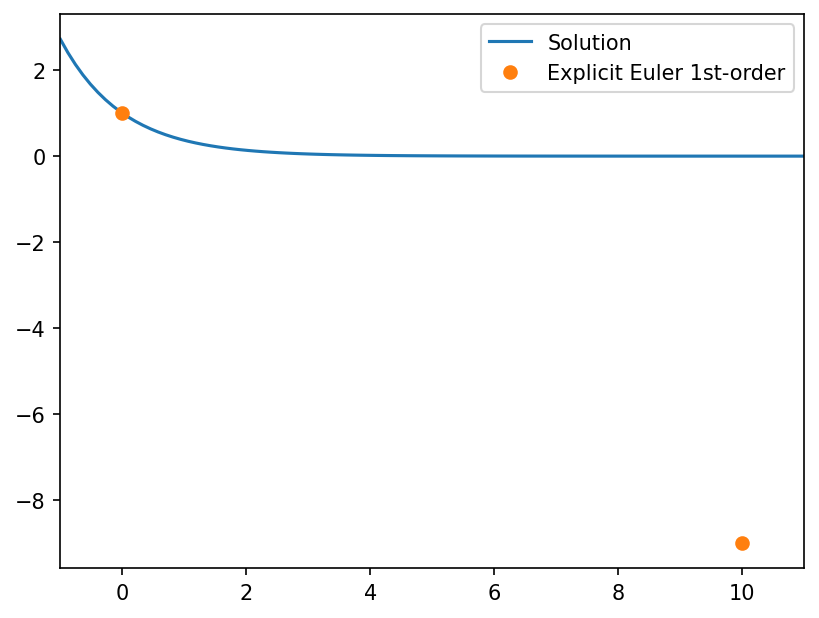

In [16]:
plot([(data_expl, "Explicit Euler 1st-order")])

In this case the step width is way too large to produce a useful result.

The only help would be to reduce the step size or to go for implicit integration.

## Background: Implicit integration

For explicit integration the derivative $f$ of the differential equation is evaluated at the current point in time or space:

$\frac{\Delta Y}{\Delta x} = \frac{Y_{n+1} - Y_n}{\Delta x} = f\left( Y_n \right)$,

which leads to the simple 1st-order Euler scheme.

$Y_{n+1} = Y_n + \Delta x\ f\left( Y_n \right)$.

Implicit integration means that the derivative is evaluated at the future point in time or space:

$\frac{Y_{n+1} - Y_n}{\Delta x} = f\left( Y_{n+1} \right)$.

What looks ridiculous at first is mathematically sound.

Imagine that the derivative can be written as a matrix equation.

$f\left( \vec{Y} \right) = \mathbf{J} \cdot \vec{Y}$,

with the Jacobian matrix $\mathbf{J}$.

Plugging this into our differential equation yields

$\vec{Y}_{n+1} - \vec{Y_n} = \Delta x\ \mathbf{J} \cdot \vec{Y}_{n+1}$

$\Leftrightarrow \left( \mathbb{1} - \Delta x\ \mathbb{J} \right) \cdot \vec{Y}_{n+1} = \vec{Y}_n$

$\Leftrightarrow \vec{Y}_{n+1} = \left( \mathbb{1} - \Delta x\ \mathbb{J} \right)^{-1} \cdot \vec{Y}_n$

The solution can be found by inverting the matrix $\mathbb{1} - \Delta x\ \mathbb{J}$.

In our simple case this translates to

$\mathbb{J} = \begin{pmatrix} b \end{pmatrix}$

and

$Y_{n+1} = \frac{1}{1-\Delta x\ b} Y_n$

For large step sizes $\left( \Delta\ x \rightarrow \infty \right)$ this goes to zero $\left( Y_n \rightarrow 0 \right)$ as it should compared to the exact solution. The integration scheme is _"unconditionally stable"_.

## Setting up implicit integration

Setting up implicit integration is similar to explicit integration. We therefore just copy our frame and reset the values.

In [17]:
import copy

In [18]:
sim_impl = copy.deepcopy(sim_expl)
sim_impl.x = 0
sim_impl.Y = A
sim_impl.writer.reset()

The important difference is now, that instead of the derivative we have to provide the Jacobian $\mathbb{J}$ to our field $Y$, which is in our case very simple. The function for the Jacobi matrix needs the parent frame object as first and the integration variable as second positional argument.

In [19]:
def jac_impl(sim, x):
    return np.array([b])
sim_impl.Y.jacobinator = jac_impl

We can now use an implicit scheme in our instruction set.

In [20]:
sim_impl.integrator.instructions = [Instruction(schemes.impl_1_euler_direct, sim_impl.Y)]

Now we can rerun the simulation.

In [21]:
sim_impl.run()

Execution time: 0:00:00


In [22]:
data_impl = sim_impl.writer.read.all()

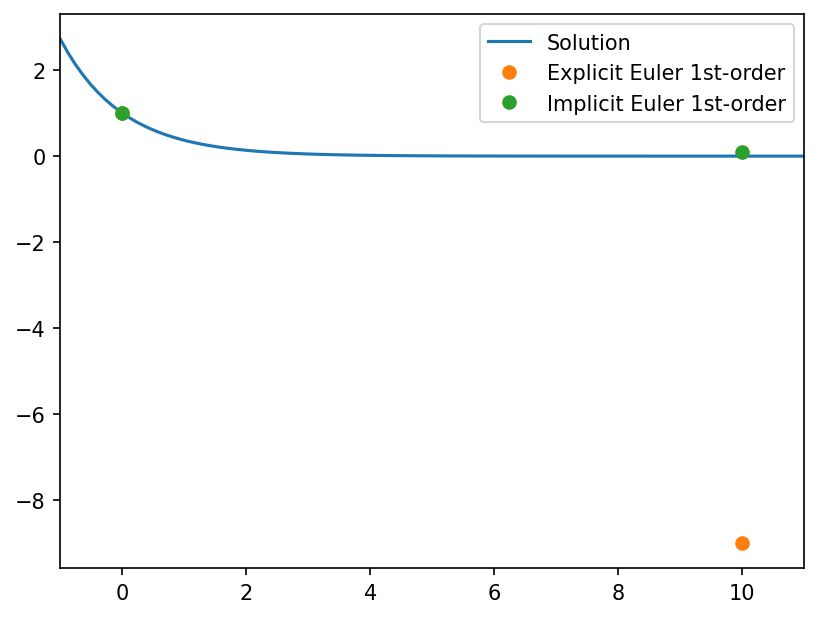

In [23]:
plot([(data_expl, "Explicit Euler 1st-order"),(data_impl, "Implicit Euler 1st-order")])

Since implicit schemes involve matrix inversions, it can be very costly. The method shown here uses `numpy.linalg.inv()` to compute the inverse matrix, which is basically Gaussian elimination with LU factorization. There are other methods that might be more suitable for your problem.

**Note:**
If the jacobinator is set, but not the differentiator, `simframe` will try to calculated the derivative from the Jacobi matrix by assuming

$\vec{Y}' = \mathbb{J} \cdot \vec{Y}$

In [24]:
sim_impl.Y.differentiator = None    # unsetting the differentiator

In [25]:
sim_impl.Y.derivative()

-0.09090909090909094

Only if neither the differentiator, nor the jacobinator are set, `Field.derivative()` will return zeros in the shape of the field, i.e., the derivative is zero.

In [26]:
sim_impl.Y.jacobinator = None

In [27]:
sim_impl.Y.derivative()

0.0